In [1]:
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from alpha_vantage.cryptocurrencies import CryptoCurrencies

api_key = '36N2WM8I8W74IFZ0'

ts = CryptoCurrencies(key="api_key", output_format="pandas")
data, meta_data= ts.get_digital_currency_daily(symbol='BTC', market = 'USD')
data = data.reindex(index=data.index[::-1])
print(data)

            1a. open (USD)  1b. open (USD)  2a. high (USD)  2b. high (USD)  \
date                                                                         
2018-07-23         7394.78         7394.78         7833.00         7833.00   
2018-07-24         7721.65         7721.65         8486.00         8486.00   
2018-07-25         8397.24         8397.24         8491.77         8491.77   
2018-07-26         8175.63         8175.63         8315.69         8315.69   
2018-07-27         7920.00         7920.00         8285.00         8285.00   
...                    ...             ...             ...             ...   
2021-04-13        59860.01        59860.01        63777.77        63777.77   
2021-04-14        63575.01        63575.01        64854.00        64854.00   
2021-04-15        62959.53        62959.53        63800.00        63800.00   
2021-04-16        63158.74        63158.74        63520.61        63520.61   
2021-04-17        61334.81        61334.81        61740.04      

In [2]:
close_data = data['4a. close (USD)']
print (close_data)

date
2018-07-23     7721.01
2018-07-24     8397.24
2018-07-25     8175.64
2018-07-26     7920.00
2018-07-27     8188.57
                ...   
2021-04-13    63575.00
2021-04-14    62959.53
2021-04-15    63159.98
2021-04-16    61334.80
2021-04-17    61210.19
Name: 4a. close (USD), Length: 1000, dtype: float64


In [3]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_data.values.reshape(-1,1))

In [4]:
prediction_days = 100

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [6]:
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
29/29 [==============================] - 7s 78ms/step - loss: 0.0192
Epoch 2/25
29/29 [==============================] - 2s 76ms/step - loss: 0.0023
Epoch 3/25
29/29 [==============================] - 2s 76ms/step - loss: 0.0022
Epoch 4/25
29/29 [==============================] - 2s 76ms/step - loss: 0.0020
Epoch 5/25
29/29 [==============================] - 2s 75ms/step - loss: 0.0027
Epoch 6/25
29/29 [==============================] - 2s 76ms/step - loss: 0.0020
Epoch 7/25
29/29 [==============================] - 2s 76ms/step - loss: 0.0022
Epoch 8/25
29/29 [==============================] - 2s 76ms/step - loss: 0.0027
Epoch 9/25
29/29 [==============================] - 2s 75ms/step - loss: 0.0016
Epoch 10/25
29/29 [==============================] - 2s 75ms/step - loss: 0.0015
Epoch 11/25
29/29 [==============================] - 2s 75ms/step - loss: 0.0021
Epoch 12/25
29/29 [==============================] - 2s 75ms/step - loss: 0.0028
Epoch 13/25
29/29 [==================

In [26]:
predicted_prices = model.predict(x_train)
predicted_prices = scaler.inverse_transform(predicted_prices)

actual_prices = data['4a. close (USD)'].values

for x in range(0, prediction_days):
    actual_prices = np.delete(actual_prices, 0)

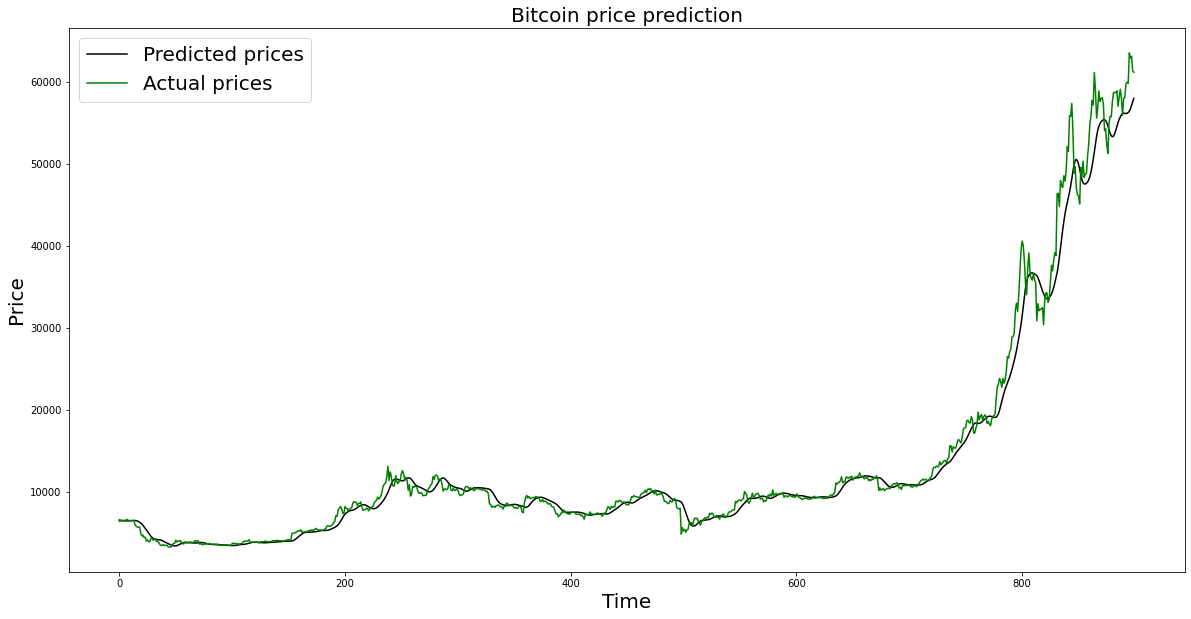

In [28]:
plt.figure(figsize=(20,10))
plt.plot(predicted_prices, color="black", label="Predicted prices")
plt.plot(actual_prices, color="green", label="Actual prices")
plt.title(f'Bitcoin price prediction', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.legend(loc='upper left', fontsize=20)
plt.show()